Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]



➡️ Training Original Model
Epoch 1, Loss: 200.4169
Epoch 2, Loss: 126.2928
Epoch 3, Loss: 99.4636
Epoch 4, Loss: 85.7972
Epoch 5, Loss: 76.1313
Epoch 6, Loss: 66.3417
Epoch 7, Loss: 59.0043
Epoch 8, Loss: 52.8467
Epoch 9, Loss: 48.1303
Epoch 10, Loss: 44.6007

🔍 Evaluating Original Model
Accuracy: 92.96%

✂️ Pruning Model (30%)

📉 Parameter Reduction Report:
Before Pruning: 11,181,642 parameters
After Pruning: 11,181,642 parameters
Reduction: 0.00%

🔍 Evaluating Pruned Model
Accuracy: 92.82%

🖼️ Visualizing Predictions


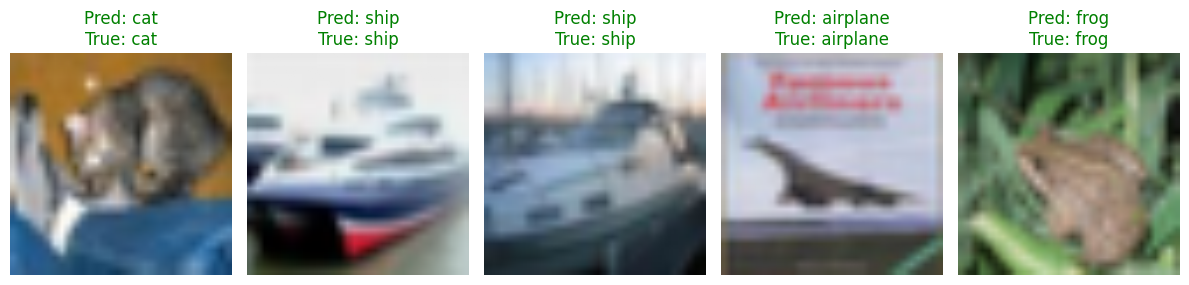

✅ Model saved as resnet18_pruned_cifar10.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ SETUP
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ TRANSFORMS & DATA (with augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# ✅ MODEL
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
model = model.to(device)

# ✅ TRAINING
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()F
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    print(f"Accuracy: {acc:.2f}%")
    return acc

# ✅ PARAM COUNT
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

original_param_count = count_parameters(model)

# ✅ TRAIN + EVAL
print("\n➡️ Training Original Model")
train_model(model, train_loader, epochs=10)

print("\n🔍 Evaluating Original Model")
original_acc = evaluate(model, test_loader)

# ✅ PRUNE
def prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

print("\n✂️ Pruning Model (30%)")
prune_model(model, amount=0.3)

pruned_param_count = count_parameters(model)
reduction = 100 * (original_param_count - pruned_param_count) / original_param_count

print("\n📉 Parameter Reduction Report:")
print(f"Before Pruning: {original_param_count:,} parameters")
print(f"After Pruning: {pruned_param_count:,} parameters")
print(f"Reduction: {reduction:.2f}%")

print("\n🔍 Evaluating Pruned Model")
pruned_acc = evaluate(model, test_loader)

# ✅ VISUALIZE PREDICTIONS
def visualize_predictions(model, loader, classes):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 3))
    for i in range(5):
        img = images[i].cpu().permute(1, 2, 0)
        img = (img * 0.5) + 0.5  # unnormalize
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}",
                  color='green' if preds[i] == labels[i] else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n🖼️ Visualizing Predictions")
visualize_predictions(model, test_loader, train_set.classes)

# ✅ SAVE & DOWNLOAD
model_path = "resnet18_pruned_cifar10.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved as {model_path}")

files.download(model_path)
